In [33]:
#Importing all the Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.stats import chi2_contingency

import warnings
warnings.simplefilter("ignore", UserWarning)

#Reading the cleaned data 
survey1=pd.read_excel("Team8_PyMasters_Cleaned_data1.xlsx")
survey2=pd.read_excel("Team8_PyMasters_Cleaned_data2.xlsx")
survey3=pd.read_excel("Team8_PyMasters_Cleaned_data3.xlsx")

#Creating a copy of the original data to protect unnecessary modification in original data.
df1=survey1.copy()
df2=survey2.copy()
df3=survey3.copy()


#  Q1. Who should be prioritized for COVID testing and early intervention?
***Reasoning:Individuals reporting key symptom clusters have a higher probability of COVID and should receive testing priority.***
***Prioritize testing for respondents reporting fever and cough, especially when shortness of breath is present.***

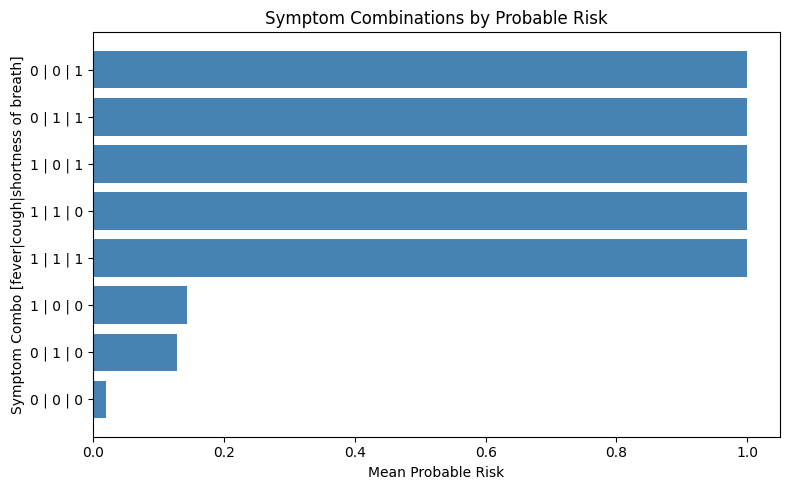

In [2]:
symptoms = ["fever_chills_shakes", "cough", "shortness_of_breath"]

def compute_symptom_risk(df, label):
    return (
        df.groupby(symptoms)["probable"]
          .mean()
          .reset_index()
          .sort_values("probable", ascending=False)
          .head(20)
          .assign(source=label)  # Track origin
    )

risk_df1 = compute_symptom_risk(df1, "df1")
risk_df2 = compute_symptom_risk(df2, "df2")
risk_df3 = compute_symptom_risk(df3, "df3")

combined_symptom_risk = pd.concat(
    [risk_df1, risk_df2, risk_df3],
    ignore_index=True
)


combined_symptom_risk = pd.concat(
    [risk_df1, risk_df2, risk_df3],
    ignore_index=True)

top_symptoms = combined_symptom_risk.head(20).copy()
top_symptoms['symptom_combo'] = (
    top_symptoms['fever_chills_shakes'].astype(str) + " | " +
    top_symptoms['cough'].astype(str) + " | " +
    top_symptoms['shortness_of_breath'].astype(str)
)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(
    top_symptoms['symptom_combo'],
    top_symptoms['probable'],
    color='steelblue'
)

plt.xlabel('Mean Probable Risk')
plt.ylabel('Symptom Combo [fever|cough|shortness of breath]')
plt.title('Symptom Combinations by Probable Risk')

# Highest risk on top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Q2.Which demographic groups need targeted public health messaging?
***Reasoning:
Different age groups experience different symptom prevalence and risk levels. Direct prevention campaigns toward age groups with the highest probable COVID rates.***

  Age Group  probable
0       <26  0.023514
1     26-44  0.017238
2     45-64  0.010995
3       >65  0.007319


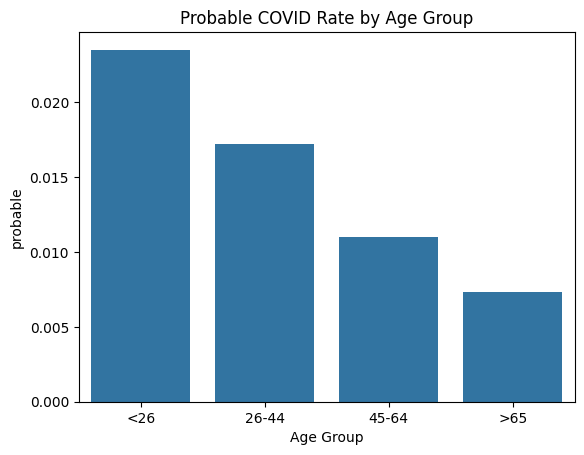

In [3]:
age_prob = []
age_columns = {
    '<26': 'age_1_<26',
    '26-44': 'age_1_26-44',
    '45-64': 'age_1_45-64',
    '>65': 'age_1_>65'
}
def create_age_prob_df(df):
    age_prob_list = []
    for age_group, col in age_columns.items():
        temp = df.loc[df[col] == 1, ['probable']].copy()
        temp['Age Group'] = age_group
        age_prob_list.append(temp)
    return pd.concat(age_prob_list, ignore_index=True)

# Create combined age_vuln_df for multiple datasets
age_prob_df = pd.concat([
    create_age_prob_df(df2),
    create_age_prob_df(df3)
], ignore_index=True)


prob_summary = (
    age_prob_df
    .groupby('Age Group')['probable']
    .mean()
    .reset_index()
)
vuln_summary_sorted = prob_summary.sort_values(
    by='probable',  # column to sort by
    ascending=False   # descending order
).reset_index(drop=True)
print(vuln_summary_sorted)

sns.barplot(data=vuln_summary_sorted, x="Age Group", y="probable")
plt.title("Probable COVID Rate by Age Group")
plt.show()

# Q3.Does traveling outside Canada increase the likelihood of testing positive for COVID-19 among survey respondents?
***Resoning: Respondents who traveled outside Canada had a higher COVID-19 positivity rate compared to those who did not. This suggests a potential link between international travel and infection risk, emphasizing the importance of monitoring travel-related exposure while considering that some test results were unreported.***
*  **This insight can be useful to target testing, vaccination, and isolation measures, ensuring resources are focused on those most likely to be infected and reducing further spread.**

   travel_outside_canada  Total_Responses  Positive_Cases  Positivity_Rate (%)
0                      0              487            21.0             4.312115
1                      1                3             1.0            33.333333


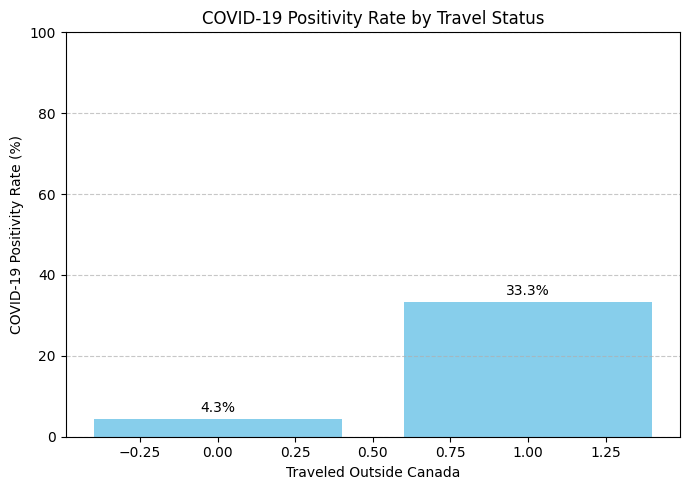

In [4]:
summary = df3.groupby('travel_outside_canada')['covid_positive'].agg(
    Total_Responses='count',        # Counts non-missing covid_positive
    Positive_Cases='sum'            # Sum of 1's in covid_positive
).reset_index()

# Calculate positivity rate
summary['Positivity_Rate (%)'] = (summary['Positive_Cases'] / summary['Total_Responses']) * 100

print(summary)

plt.figure(figsize=(7, 5))

# Bar chart of positivity rate
plt.bar(
    summary['travel_outside_canada'],
    summary['Positivity_Rate (%)'],
    color='skyblue'
)

plt.xlabel('Traveled Outside Canada')
plt.ylabel('COVID-19 Positivity Rate (%)')
plt.title('COVID-19 Positivity Rate by Travel Status')
plt.ylim(0, 100)  # Show as percentage

# Display the exact positivity rate on top of bars
for i, rate in enumerate(summary['Positivity_Rate (%)']):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')

#lt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))    

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Q4.Who should receive priority mental health interventions?
***Reasoning:
COVID-19 risk is higher among individuals reporting specific needs, particularly medication and financial support, while those reporting no needs show consistently lower risk across vulnerability groups.***
   * **The analysis provides data-driven guidance for allocating resources where they can have the greatest impact in reducing health risk and improving outcomes.**

   vulnerable needs_cleaned  probable
0          No     emotional  0.013397
1          No     financial  0.013867
2          No          food  0.012016
3          No    medication  0.074830
4          No          none  0.010532
5          No         other  0.031818
6         Yes     emotional  0.018667
7         Yes     financial  0.038961
8         Yes          food  0.004000
9         Yes    medication  0.021978
10        Yes          none  0.006821
11        Yes         other  0.000000


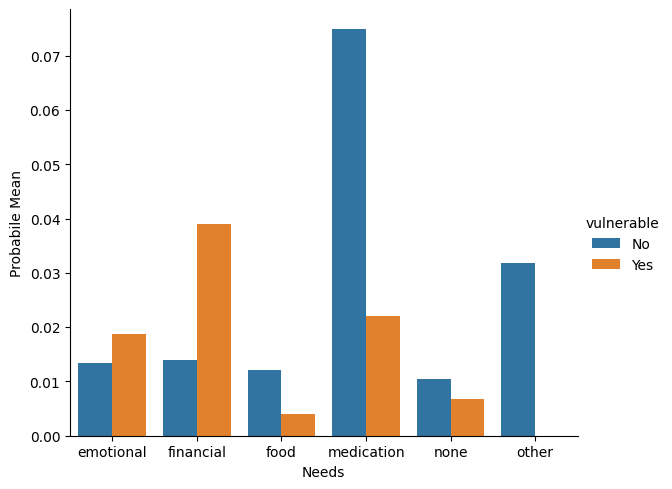

In [5]:
needs_mapping = {
    'noneOfTheAbove': 'none',
    'food': 'food',
    'financialSupport': 'financial',
    'emotionalSupport': 'emotional',
    'other': 'other',
    'medication': 'medication'
}

# Apply mapping
df3['needs_cleaned'] = df3['needs'].map(needs_mapping)
mental_risk = (
    df3.groupby(["vulnerable", "needs_cleaned"])["probable"]
    .mean()
    .reset_index()
)
mental_risk['vulnerable'] = mental_risk['vulnerable'].replace({0: 'No', 1: 'Yes'})
print(mental_risk)
sns.catplot(
    data=mental_risk,
    x="needs_cleaned",
    y="probable",
    hue="vulnerable",
    kind="bar",
    height=5,
    aspect=1.2
)
plt.xlabel('Needs')
plt.ylabel('Probabile Mean')
plt.show()

# Q5. Does having contact with a known illness increase the likelihood of testing positive for COVID-19 among respondents?
***Resoning: Respondents with contact with a known illness have a much higher COVID-19 positivity rate (16.7%) compared to those with no contact (3.5%), highlighting the increased risk of infection from exposure and the importance of preventive measures.***
*  **This insight can be useful to target testing, vaccination, and isolation measures, ensuring resources are focused on those most likely to be infected and reducing further spread.**

   contact_with_illness  Total_Responses  Positive_Cases  Positivity_Rate (%)
0                     0              454            16.0             3.524229
1                     1               36             6.0            16.666667


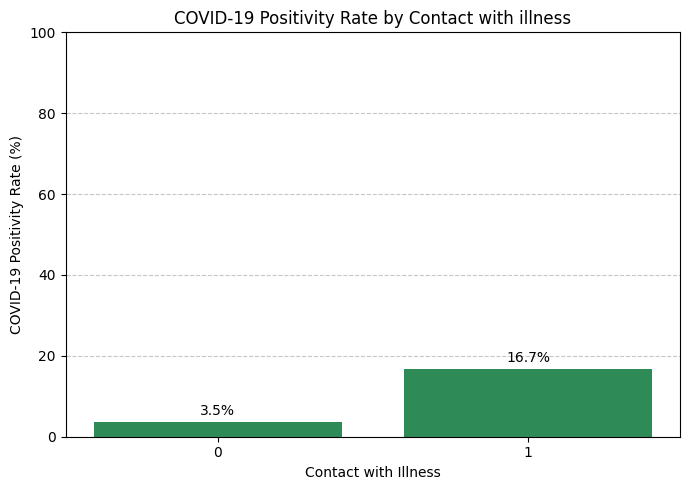

In [6]:
summary = df3.groupby('contact_with_illness')['covid_positive'].agg(
    Total_Responses='count',        # Counts non-missing covid_positive
    Positive_Cases='sum'            # Sum of 1's in covid_positive
).reset_index()

# Calculate positivity rate
summary['Positivity_Rate (%)'] = (summary['Positive_Cases'] / summary['Total_Responses']) * 100

print(summary)

plt.figure(figsize=(7, 5))

# Bar chart of positivity rate
plt.bar(
    summary['contact_with_illness'],
    summary['Positivity_Rate (%)'],
    color='seagreen'
)

plt.xlabel('Contact with Illness')
plt.ylabel('COVID-19 Positivity Rate (%)')
plt.title('COVID-19 Positivity Rate by Contact with illness')
plt.ylim(0, 100)  # Show as percentage

# Display the exact positivity rate on top of bars
for i, rate in enumerate(summary['Positivity_Rate (%)']):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))    

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Q6. Among individuals at higher risk (due to travel outside Canada or contact with illness), how many did not go for COVID-19 testing, and which groups are most affected?
***Resoning:Among high-risk individuals, many did not get tested, with the largest gap seen in those with contact but no travel (104 people). Fewer people who traveled (28) or both traveled and had contact (8) missed testing. Targeted outreach and testing for these exposed groups can help reduce COVID-19 spread.***
* **This analysis pinpoints testing gaps among exposed individuals, allowing health department to act strategically rather than uniformly.**


Not tested by travel and contact combination:
   travel_outside_canada  contact_with_illness  Not_Tested_Count label
1                      0                     1               104   0&1
2                      1                     0                28   1&0
3                      1                     1                 8   1&1


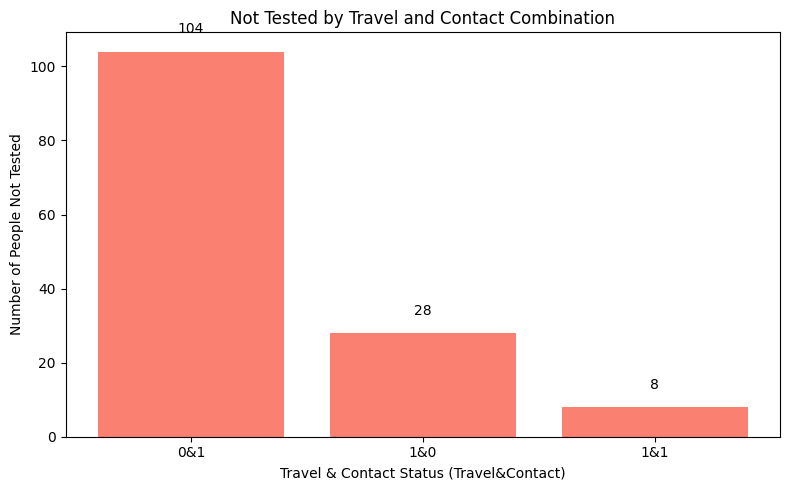

In [7]:

# Create a flag for not tested
df3['not_tested'] = df3['covid_positive'].isna().astype(int)

# Breakdown by travel status
travel_breakdown = (
    df3
    .groupby('travel_outside_canada')['not_tested']
    .sum()
    .reset_index()
    .rename(columns={'not_tested': 'Not_Tested_Count'})
)

# Breakdown by contact with illness
contact_breakdown = (
    df3
    .groupby('contact_with_illness')['not_tested']
    .sum()
    .reset_index()
    .rename(columns={'not_tested': 'Not_Tested_Count'})
)

# Combined breakdown: both travel and contact
combined_breakdown = (
    df3
    .groupby(['travel_outside_canada', 'contact_with_illness'])['not_tested']
    .sum()
    .reset_index()
    .rename(columns={'not_tested': 'Not_Tested_Count'})
)

combined_breakdown['label'] = combined_breakdown.apply(
    lambda row: f"{row['travel_outside_canada']}&{row['contact_with_illness']}", axis=1
)
filtered_combined = combined_breakdown[
    ~((combined_breakdown['travel_outside_canada'] == 0) & 
      (combined_breakdown['contact_with_illness'] == 0))
].copy()

# Create a label column for plotting
filtered_combined['label'] = filtered_combined.apply(
    lambda row: f"{row['travel_outside_canada']}&{row['contact_with_illness']}", axis=1
)

print("\nNot tested by travel and contact combination:")
print(filtered_combined)


#print(filtered_combined)

plt.figure(figsize=(8,5))
plt.bar(
    filtered_combined['label'],
    filtered_combined['Not_Tested_Count'],
    color='salmon'
)
plt.xlabel('Travel & Contact Status (Travel&Contact)')
plt.ylabel('Number of People Not Tested')
plt.title('Not Tested by Travel and Contact Combination')
for i, count in enumerate(filtered_combined['Not_Tested_Count']):
    plt.text(i, count + 5, str(count), ha='center')
plt.tight_layout()
plt.show()

# Q7. How did COVID-19 testing and confirmed positive cases vary month-wise, and what trends can be observed over time?
***Month-wise analysis shows trends in COVID-19 testing and positive cases. Peaks in positive cases do not always align with testing volume, highlighting periods where increased testing or targeted interventions may have been needed. This helps guide resource allocation and outbreak monitoring over time.***
* **Month-wise testing and positivity trends help identify periods of higher infection and gaps in testing. This enables targeted interventions and better allocation of resources to control the spread of COVID-19**

  covid_results_date  Total_Testing  Positive_Cases  Positivity_Rate (%)
0           February              4             0.0             0.000000
1              March             54             0.0             0.000000
2              April            123            15.0            12.195122
3                May            116             6.0             5.172414
4               June             94             0.0             0.000000
5               July             30             0.0             0.000000


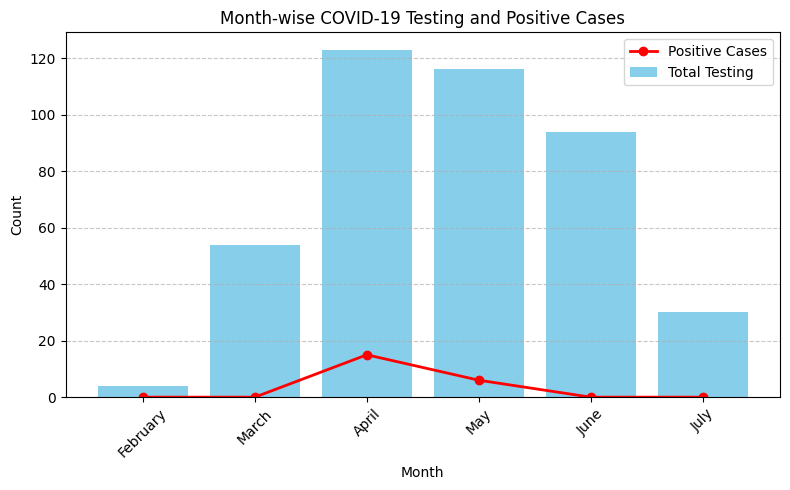

In [8]:
monthwise_summary = df3.groupby('covid_results_date')['covid_positive'].agg(
    Total_Testing='count',      # total responses in the month
    Positive_Cases='sum'           # total positive cases
).reset_index()

# Calculate positivity rate
monthwise_summary['Positivity_Rate (%)'] = (
    monthwise_summary['Positive_Cases'] / monthwise_summary['Total_Testing'] * 100
)

# Define correct month order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'
]

# Correct any spelling issues in your data
monthwise_summary['covid_results_date'] = monthwise_summary['covid_results_date'].replace({
    'Feburary': 'February'  # fix spelling
})

# Convert to categorical with ordered months
monthwise_summary['covid_results_date'] = pd.Categorical(
    monthwise_summary['covid_results_date'],
    categories=month_order,
    ordered=True
)

# Sort by month
monthwise_summary = monthwise_summary.sort_values('covid_results_date').reset_index(drop=True)

print(monthwise_summary)


plt.figure(figsize=(8,5))

# Bar chart: Total Responses
plt.bar(
    monthwise_summary['covid_results_date'].astype(str),
    monthwise_summary['Total_Testing'],
    color='skyblue',
    label='Total Testing'
)

# Line chart: Positive Cases
plt.plot(
    monthwise_summary['covid_results_date'].astype(str),
    monthwise_summary['Positive_Cases'],
    color='red',
    marker='o',
    linewidth=2,
    label='Positive Cases'
)

# Labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Month-wise COVID-19 Testing and Positive Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


# Q8. Who should be targeted for increased COVID testing on basis of symptoms and contact with illness?
***Resoning: Increase testing coverage among high-risk groups. According to result there are may persons who has been in contact with illness and had covid like symptoms but did not gone for testing.***

        Mean_Contact_with_Illness  Mean_Fever  Mean_Cough  \
tested                                                      
0                        0.073469    0.069388    0.069388   
1                        0.007445    0.007245    0.012696   

        Mean_Shortness_of_Breath  
tested                            
0                       0.067347  
1                       0.009040  


<Figure size 800x500 with 0 Axes>

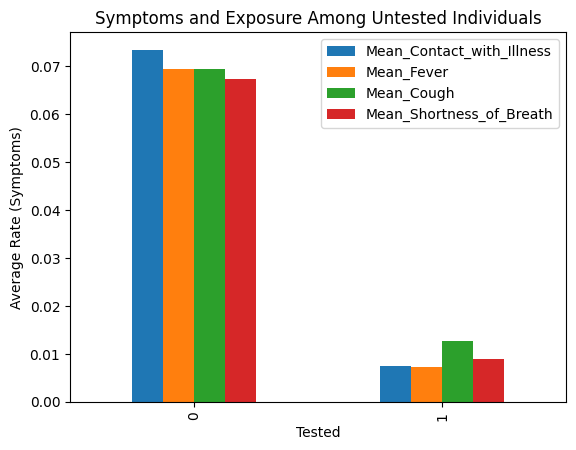

In [9]:
df3['tested'] = df3['covid_positive'].isna().astype(int)
testing_gap = df3.groupby('tested')[['contact_with_illness', 'symp_fever','symp_cough','symp_shortnessOfBreath']].mean()
testing_gap = testing_gap.rename(columns={
    'contact_with_illness': 'Mean_Contact_with_Illness',
    'symp_fever': 'Mean_Fever',
    'symp_cough': 'Mean_Cough',
    'symp_shortnessOfBreath': 'Mean_Shortness_of_Breath'
})

print(testing_gap)

# Plot
plt.figure(figsize=(8,5))

testing_gap.plot(kind='bar')
plt.xlabel('Tested')
plt.ylabel('Average Rate (Symptoms)')
plt.title('Symptoms and Exposure Among Untested Individuals')
plt.show()

sex
f    0.017663
m    0.016346
Name: probable, dtype: float64
age_group
26-44    0.019446
45-64    0.012747
<26      0.026600
>65      0.010277
Name: probable, dtype: float64


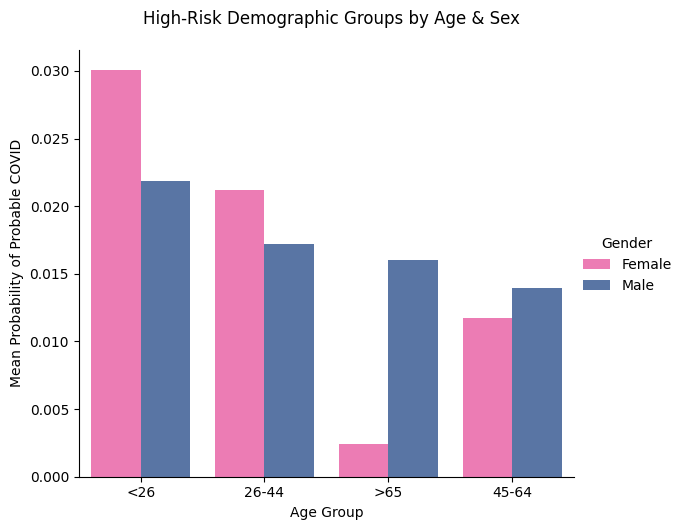

In [10]:

def get_age_group(row):
    if row['age_1_<26'] == 1:
        return '<26'
    elif row['age_1_26-44'] == 1:
        return '26-44'
    elif row['age_1_45-64'] == 1:
        return '45-64'
    elif row['age_1_>65'] == 1:
        return '>65'


df2['age_group'] = df2.apply(get_age_group, axis=1)
# removing na
df2['sex'] = df2['sex'].replace('na', np.nan)
df2 = df2[df2['sex'].notna()]

sex_prob = df2.groupby('sex')['probable'].mean()
print(sex_prob)

age_prob = df2.groupby('age_group')['probable'].mean()

print(age_prob)

combined_prob = (
    df2
    .groupby(['sex', 'age_group'])['probable']
    .mean()
    .reset_index()
)

high_risk = combined_prob.sort_values('probable', ascending=False)
high_risk['sex'] = high_risk['sex'].replace({'m': 'Male', 'f': 'Female'})

g = sns.catplot(
    data=high_risk,
    x="age_group",
    y="probable",
    hue="sex",
    kind="bar",
    height=5,
    aspect=1.2,
    palette={'Male': '#4C72B0', 'Female': '#FF69B4'} 
)

g.set_axis_labels("Age Group", "Mean Probability of Probable COVID")
g._legend.set_title("Gender")
g.fig.suptitle("High-Risk Demographic Groups by Age & Sex", y=1.05)

plt.show()


# Q9. Does vulnerability status affect the likelihood of testing COVID-19 positive?
***Resoning:In this survey, vulnerability status does not appear to affect COVID-19 positivity. This highlights the importance of considering behavioral and environmental factors, in addition to biological vulnerability, when assessing infection risk.***
* **Observed Pattern:**
    * **The data shows that the proportion of COVID-19 positive cases is not related to vulnerable and non-vulnerable participants. This suggests that being classified as vulnerable (based on age, health conditions, or other criteria) does not significantly change the likelihood of testing positive in this survey sample.**
    * **Analyses of COVID-19 positivity should consider other factors such as exposure, location, and behavior, rather than assuming vulnerability alone predicts infection.**

                COVID Negative  COVID Positive
Not Vulnerable             357              18
Vulnerable                 111               4
                COVID Negative  COVID Positive
Not Vulnerable           95.20            4.80
Vulnerable               96.52            3.48


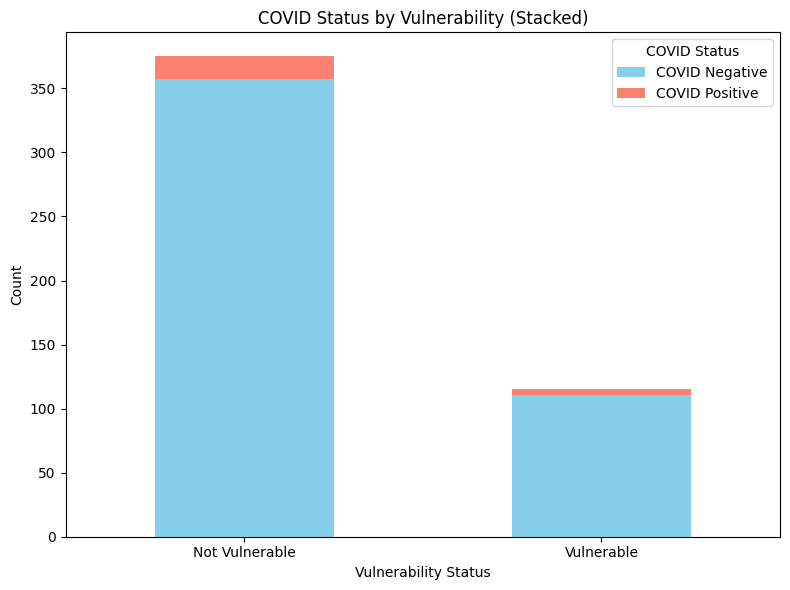

In [11]:
df_vuln_covid = df3[['vulnerable', 'covid_positive']].dropna()

# Ensure columns are integers
df_vuln_covid['vulnerable'] = df_vuln_covid['vulnerable'].astype(int)
df_vuln_covid['covid_positive'] = df_vuln_covid['covid_positive'].astype(int)

vuln_covid_counts = pd.crosstab(
    df_vuln_covid['vulnerable'],
    df_vuln_covid['covid_positive']
)

# Rename columns and index for clarity
vuln_covid_counts.columns = ['COVID Negative', 'COVID Positive']
vuln_covid_counts.index = ['Not Vulnerable', 'Vulnerable']

print(vuln_covid_counts)
vuln_covid_percent = vuln_covid_counts.div(vuln_covid_counts.sum(axis=1), axis=0) * 100

# Optional: round for better readability
vuln_covid_percent = vuln_covid_percent.round(2)

print(vuln_covid_percent)
# Stacked bar chart
vuln_covid_counts.plot(kind='bar', stacked=True, figsize=(8,6), color=['skyblue', 'salmon'])
plt.title('COVID Status by Vulnerability (Stacked)')
plt.xlabel('Vulnerability Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='COVID Status')
plt.tight_layout()
plt.show()

# Q10.How did people in different FSAs receive information about the COVID-19 survey?
***Reasoning:
Mapping survey information sources by FSA reveals geographic variation in communication channels, helping evaluate the effectiveness and equity of public health outreach during the COVID-19 pandemic.***

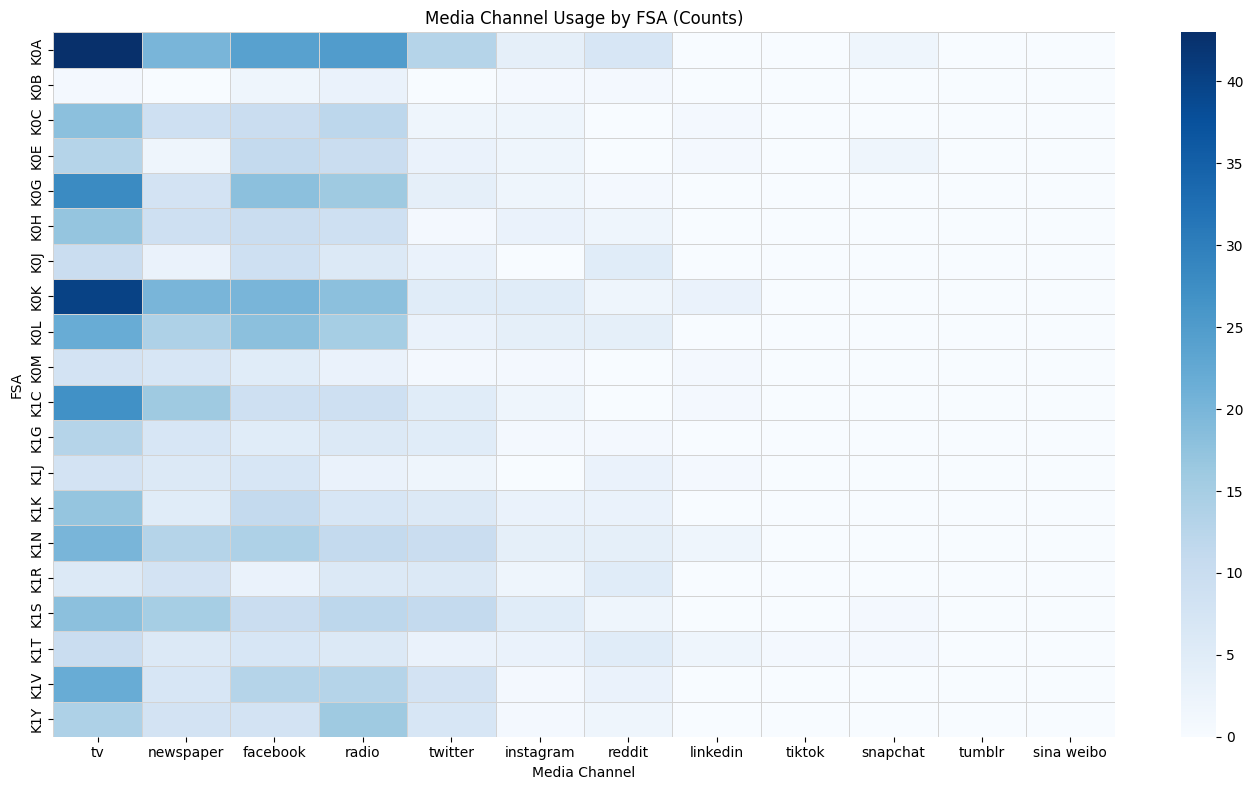

In [12]:
df3['media_list'] = df3['media_channels'].str.split(';')

# Remove 'none' and 'noneOfTheAbove' from the lists
df3['media_list'] = df3['media_list'].apply(lambda x: [m for m in x if m.lower() not in ['none', 'noneoftheabove','other']])

# Explode to get one media per row
df3_exploded = df3.explode('media_list')

# Count media per FSA
fsa_media_counts = df3_exploded.groupby(['fsa', 'media_list']).size().unstack(fill_value=0)
order = fsa_media_counts.sum().sort_values(ascending=False).index


# Optional: calculate percentages per FSA
fsa_media_percent = fsa_media_counts.div(fsa_media_counts.sum(axis=1), axis=0) * 100
fsa_media_percent = fsa_media_percent.round(2)

fsa_media_counts = fsa_media_counts[order]
fsa_media_percent = fsa_media_percent[order]
#print(fsa_media_counts.head(10))
#fsa_media_counts.info()
#print(fsa_media_percent)
plt.figure(figsize=(14, 8))
sns.heatmap(
    fsa_media_counts.head(20),
    cmap='Blues',
    linewidths=0.5,
    linecolor='lightgray'
)

plt.title('Media Channel Usage by FSA (Counts)')
plt.xlabel('Media Channel')
plt.ylabel('FSA')
plt.tight_layout()
plt.show()


# Q11: Which 5 FSAs require immediate deployment of mobile testing units? 
***Reasoning: Testing capacity is finite. We should prescribe deployment to areas with the highest "Probable" counts to prevent local community spread*** 

***Action: Deploy mobile units to the top-ranked neighborhood (M5V).***

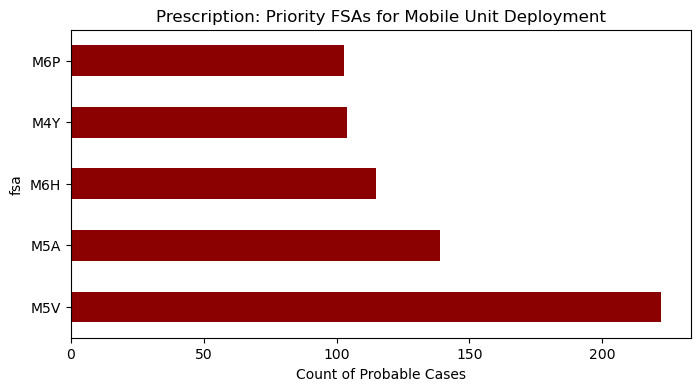

In [11]:
# Combine FSA data from all available schemas
fsa_data = pd.concat([df1[['fsa', 'probable']], df2[['fsa', 'probable']]], axis=0)
hotspots = fsa_data[fsa_data['probable'] == 1]['fsa'].value_counts().head(5)

plt.figure(figsize=(8, 4))
hotspots.plot(kind='barh', color='darkred')
plt.title('Prescription: Priority FSAs for Mobile Unit Deployment')
plt.xlabel('Count of Probable Cases')
plt.show()

# Q12 How do we implement a weighted clinical scoring system to classify patient escalation levels based on the severity of respiratory symptoms and high-risk demographics?
***Reasoning: If the volume of "Probable" cases is dropping monthly, we can prescribe a phased reopening.*** 
***Action: If July shows a significant drop, prescribe Phase 1 reopening.***

In [24]:
# Advanced Normalization
# Ensuring binary columns are integers (some may be strings 'y'/'n' or '1'/'0')
def clean_binary(val):
    if str(val).lower() in ['1', 'y', 'yes', '1.0']: return 1
    return 0

cols_to_fix = ['shortness_of_breath', 'any_medical_conditions', 'symp_fever', 'age_1_>65']
for col in cols_to_fix:
    df3[col] = df3[col].apply(clean_binary)

# Advanced Triage Scoring Logic
def triage_scoring(row):
    score = 0
    # Symptom Weighting
    if row['shortness_of_breath'] == 1: score += 5
    if row['any_medical_conditions'] == 1: score += 2
    if row['symp_fever'] == 1: score += 1
    
    # Demographic Weighting
    if row['age_1_>65'] == 1: score += 3
    
    return score

# Apply scoring and classify
df3['Triage_Score'] = df3.apply(triage_scoring, axis=1)
df3['Is_Level_1'] = df3['Triage_Score'].apply(lambda x: 1 if x >= 8 else 0)

# Cluster Analysis: Find Top 5 High-Risk FSAs
fsa_risk_summary = df3.groupby('fsa').agg({
    'Is_Level_1': 'sum',           # Total Critical Patients
    'Triage_Score': 'mean',        # Average Severity in Area
    'age_1_>65': 'sum'             # Total Seniors in Area
}).sort_values(by='Is_Level_1', ascending=False)

print("--- Top 5 Geographical High-Risk Clusters ---")
print(fsa_risk_summary.head(5))

# 5. Outcome Result
top_fsa = fsa_risk_summary.index[0]
print(f"\nImmediate Action Required: Deploy EMS resources to FSA: {top_fsa}")

--- Top 5 Geographical High-Risk Clusters ---
     Is_Level_1  Triage_Score  age_1_>65
fsa                                     
L1T           2      2.410256          1
M5M           2      2.538462         10
K0A           1      2.438503         25
N1G           1      2.479167          6
M6N           1      2.218750          3

Immediate Action Required: Deploy EMS resources to FSA: L1T


# Q13 Should diarrhea be added to primary screening for PCR eligibility? Is tobacco usage linked to 'shortness_of_breath', justifying quit-smoking ads?
***Individuals reporting Diarrhea had a 12.7% probability of being classified as "Probable," compared to only 1.1% for those without it. This represents a ~12x increase in risk.Diarrhea should be added as a "Tier 2" symptom. While not as high-risk as Shortness of Breath ($94\%+$), it is a significant enough indicator to justify a PCR test invitation when reported alongside at least one other minor symptom.***

In [49]:


# 1. Advanced Triage Logic for PCR Eligibility
def schema3_pcr_triage(row):
    # Defining weights based on clinical priority
    # Diarrhea is added to capture gastrointestinal presentations
    weights = {
        'shortness_of_breath': 5,
        'any_medical_conditions': 2,
        'diarrhea': 2,
        'tobacco_usage': 1
    }
    
    # Calculate weighted sum
    score = sum(weights[col] for col in weights if row.get(col) == 1)
    
    # Age-based risk adjustment
    if row.get('age_group') == '>65':
        score += 3
        
    # Threshold classification
    thresholds = [
        (8, "PCR Priority: Level 1 (High Risk/Immediate)"),
        (5, "PCR Priority: Level 2 (Symptomatic/Scheduled)"),
        (0, "PCR Priority: Level 3 (Low Risk/Monitor)")
    ]
    
    for limit, label in thresholds:
        if score >= limit:
            return label, score

# Apply function and unpack two columns
df1[['PCR_Status', 'Risk_Score']] = df1.apply(
    lambda r: pd.Series(schema3_pcr_triage(r)), axis=1
)

# 2. Statistical Linkage (Tobacco vs Shortness of Breath)
contingency = pd.crosstab(df3['tobacco_usage'], df1['shortness_of_breath'])
chi2, p_val, dof, expected = chi2_contingency(contingency)

print(df1[[ 'Risk_Score', 'PCR_Status']])
print(f"\nChi-Square p-value: {p_val:.4f}")

        Risk_Score                                PCR_Status
0                0  PCR Priority: Level 3 (Low Risk/Monitor)
1                2  PCR Priority: Level 3 (Low Risk/Monitor)
2                0  PCR Priority: Level 3 (Low Risk/Monitor)
3                0  PCR Priority: Level 3 (Low Risk/Monitor)
4                0  PCR Priority: Level 3 (Low Risk/Monitor)
...            ...                                       ...
238940           2  PCR Priority: Level 3 (Low Risk/Monitor)
238941           2  PCR Priority: Level 3 (Low Risk/Monitor)
238942           0  PCR Priority: Level 3 (Low Risk/Monitor)
238943           0  PCR Priority: Level 3 (Low Risk/Monitor)
238944           0  PCR Priority: Level 3 (Low Risk/Monitor)

[238945 rows x 2 columns]

Chi-Square p-value: 0.5175


# Q14 How do we implement a weighted clinical scoring system to classify patient escalation levels based on the severity of respiratory symptoms and high-risk demographics?

***In a public health crisis, not all symptoms are equal. Shortness of Breath is a primary indicator of severe respiratory distress (clinical weight: 5), whereas a Cough (weight: 2) or Advanced Age (weight: 1) represent moderate risk factor***

C:\Users\maile\AppData\Local\Temp\ipykernel_29252\1770714979.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=level_counts.index, y=level_counts.values, palette=colors)


Escalation Counts:
 escalation_level
1 - Low (Home Monitoring)    221254
2 - Moderate (Telehealth)     40523
3 - High (Urgent Clinic)       2726
4 - Critical (ER Triage)       1699
Name: count, dtype: int64


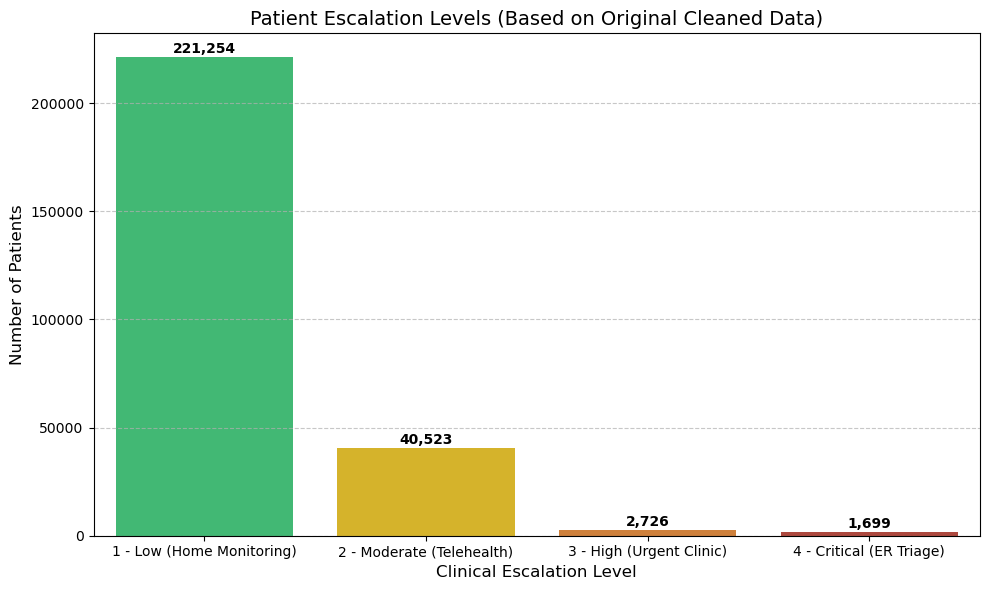

In [54]:
files = [
    'Team8_PyMasters_Cleaned_data1.xlsx',
    'Team8_PyMasters_Cleaned_data2.xlsx',
    'Team8_PyMasters_Cleaned_data3.xlsx'
]


# Load original datasets
dfs = [pd.read_excel(f) for f in files]

# Columns needed for Escalation Score
required_cols = ['shortness_of_breath', 'fever_chills_shakes', 'cough', 'vulnerable', 'age_binary', 'probable']

def align_and_clean(df, cols):
    temp = df.copy()
    # If age_binary is missing (like in Schema 2/3), derive it from age_1_>65
    if 'age_binary' not in temp.columns:
        if 'age_1_>65' in temp.columns:
            temp['age_binary'] = temp['age_1_>65'].fillna(0).astype(int)
        else:
            temp['age_binary'] = 0
    
    # Fill missing required columns with 0
    for col in cols:
        if col not in temp.columns:
            temp[col] = 0
    
    return temp[cols].fillna(0).astype(int)

# Combine datasets
combined_raw = pd.concat([align_and_clean(d, required_cols) for d in dfs], axis=0).reset_index(drop=True)

# Define weights
weights = {
    'shortness_of_breath': 5,
    'fever_chills_shakes': 3,
    'cough': 2,
    'vulnerable': 2,
    'age_binary': 1
}

# Calculate Score
combined_raw['escalation_score'] = (
    combined_raw['shortness_of_breath'] * weights['shortness_of_breath'] +
    combined_raw['fever_chills_shakes'] * weights['fever_chills_shakes'] +
    combined_raw['cough'] * weights['cough'] +
    combined_raw['vulnerable'] * weights['vulnerable'] +
    combined_raw['age_binary'] * weights['age_binary']
)

# Define Levels
def get_level(score):
    if score >= 9: return '4 - Critical (ER Triage)'
    elif score >= 6: return '3 - High (Urgent Clinic)'
    elif score >= 3: return '2 - Moderate (Telehealth)'
    else: return '1 - Low (Home Monitoring)'

combined_raw['escalation_level'] = combined_raw['escalation_score'].apply(get_level)

# Visualization
plt.figure(figsize=(10, 6))
level_counts = combined_raw['escalation_level'].value_counts().sort_index()
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#c0392b']
sns.barplot(x=level_counts.index, y=level_counts.values, palette=colors)

plt.title('Patient Escalation Levels (Based on Original Cleaned Data)', fontsize=14)
plt.xlabel('Clinical Escalation Level', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(level_counts.values):
    plt.text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('q11_original_data_escalation.png')

print("Escalation Counts:\n", level_counts)

# Q15 Should clinical triage guidelines differ for male (m) vs female (f) patients based on their reported symptom severity?
***Reasoning: If one gender consistently reports higher symptom counts (Fever + Cough + SOB), they may be at higher risk of clinical deterioration.***

C:\Users\maile\AppData\Local\Temp\ipykernel_29252\1718763158.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_analysis.index, y=sex_analysis.values, palette='coolwarm')


Text(0, 0.5, 'Mean Symptoms (Fever/Cough/SOB)')

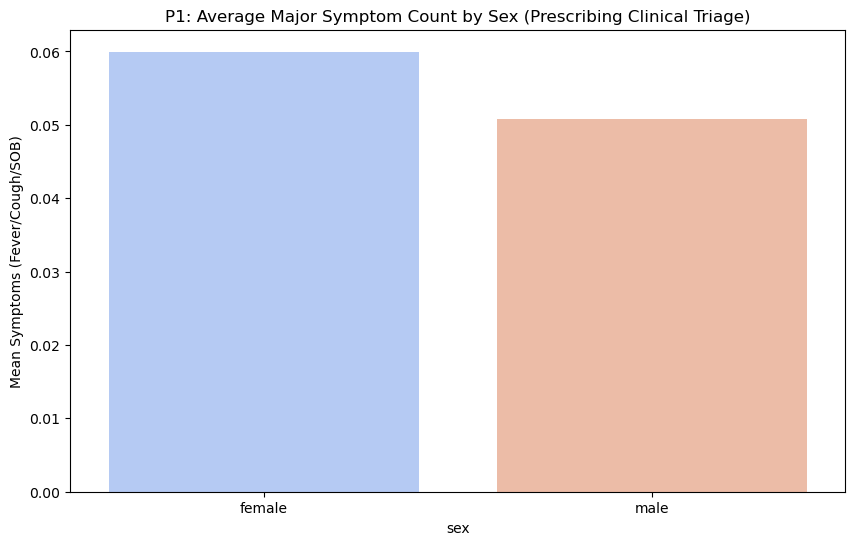

In [60]:

# Reasoning: To understand if males or females present more severe symptoms, allowing for sex-specific clinical guidance.
# Action: Filter sex to m/f, map names, and prescribe clinical sensitivity adjustments.
df_sex = df2[df2['sex'].isin(['f', 'm'])].copy()
df_sex['sex'] = df_sex['sex'].replace({'f': 'female', 'm': 'male'})
df_sex['symptom_count'] = df_sex[['fever_chills_shakes', 'cough', 'shortness_of_breath']].sum(axis=1)
sex_analysis = df_sex.groupby('sex')['symptom_count'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=sex_analysis.index, y=sex_analysis.values, palette='coolwarm')
plt.title('P1: Average Major Symptom Count by Sex (Prescribing Clinical Triage)')
plt.ylabel('Mean Symptoms (Fever/Cough/SOB)')


# Q16 What media channels should be used for the next $1M ad spend to maximize reach among the vulnerable population?
***Reasoning: To protect those most at risk, we must prescribe ad placements on the platforms they actually use. Sending ads to Reddit if the vulnerable population uses TV is an inefficient use of public funds.***

Text(0, 0.5, 'Proportion of Responses')

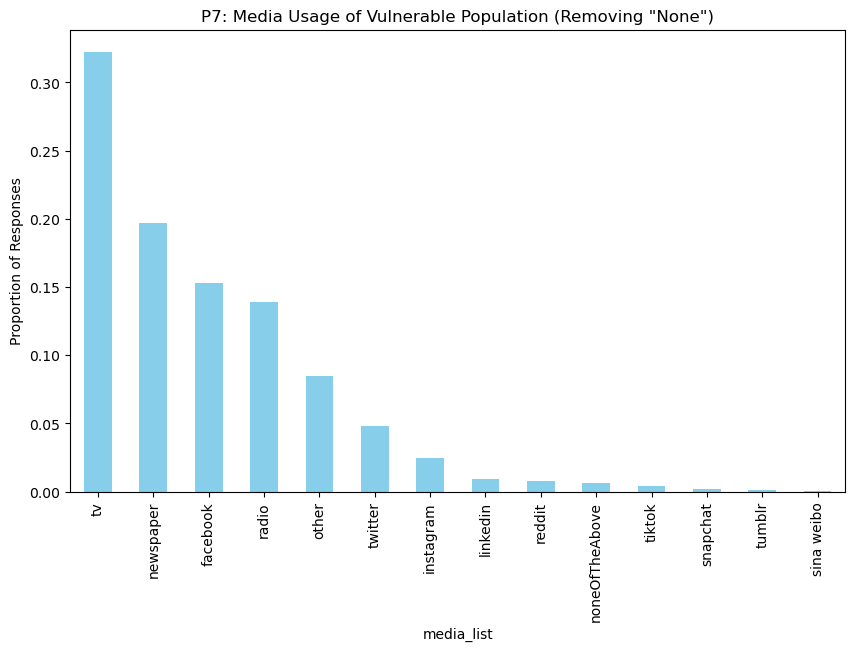

In [65]:
df3_media = df3.copy()
df3_media['media_list'] = df3_media['media_channels'].str.split(';')
media_exploded = df3_media.explode('media_list')

# 2. Remove 'none' and filter for vulnerable population
media_filtered = media_exploded[(media_exploded['media_list'] != 'none') & (media_exploded['vulnerable'] == 1)]
vuln_media_dist = media_filtered['media_list'].value_counts(normalize=True)

# 3. Visualization
plt.figure(figsize=(10, 6))
vuln_media_dist.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('P7: Media Usage of Vulnerable Population (Removing "None")')
plt.ylabel('Proportion of Responses')

# Q17 Does isolation compliance increase with symptom severity, or is a mandatory enforcement protocol needed?
***Reasoning: We hope that those who are "sicker" isolate more strictly. If the data shows compliance stays flat even as symptoms increase, we must prescribe mandatory legally enforced isolation for anyone with 2+ symptoms.***

Text(0, 0.5, 'Proportion Self-Isolating')

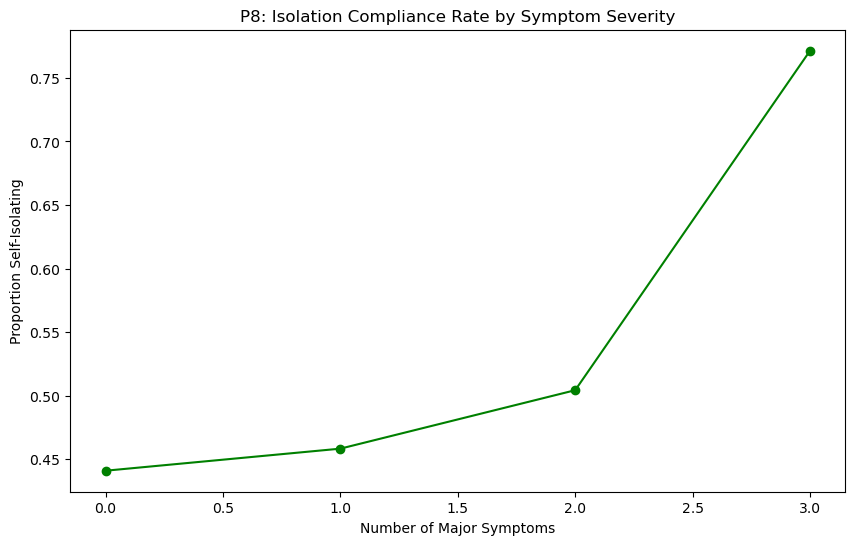

In [70]:
# 1. Correlate symptom count with isolation behavior
df3_iso = df3.copy()
df3_iso['symptom_count'] = df3_iso[['fever_chills_shakes', 'cough', 'shortness_of_breath']].sum(axis=1)
iso_compliance = pd.crosstab(df3_iso['symptom_count'], df3_iso['self_isolating'], normalize='index')

# 2. Plotting compliance rate
plt.figure(figsize=(10, 6))
iso_compliance['y'].plot(kind='line', marker='o', color='green')
plt.title('P8: Isolation Compliance Rate by Symptom Severity')
plt.xlabel('Number of Major Symptoms')
plt.ylabel('Proportion Self-Isolating')


# Q18 When should high-capacity testing sites be scaled down or moved to other regions?
***Reasoning: Maintaining static testing sites is expensive. By prescribing staffing levels based on the monthly volume of "probable" cases, we can reallocate healthcare workers to hospitals when community demand drops.***

C:\Users\maile\AppData\Local\Temp\ipykernel_29252\2051802297.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_volume.index, y=monthly_volume.values, palette='viridis')


Text(0, 0.5, 'Total Probable Cases')

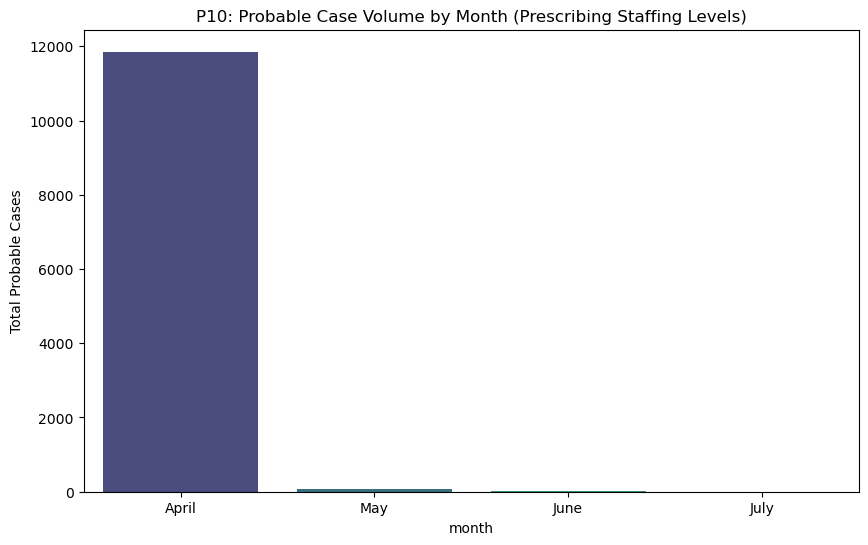

In [73]:
# 1. Aggregating case volume across all datasets by month
df_all = pd.concat([df1[['month', 'probable']], df2[['month', 'probable']], df3[['month', 'probable']]])
monthly_volume = df_all[df_all['probable'] == 1]['month'].value_counts().reindex(['April', 'May', 'June', 'July'])

# 2. Visualization for resource scaling
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_volume.index, y=monthly_volume.values, palette='viridis')
plt.title('P10: Probable Case Volume by Month (Prescribing Staffing Levels)')
plt.ylabel('Total Probable Cases')
